In [1]:
#code shared in assignment.
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import sys
# Import custom functions from scripts directory.
sys.path.append('scripts')
import color_functions as color
import io_functions as io
import warp_functions as warp



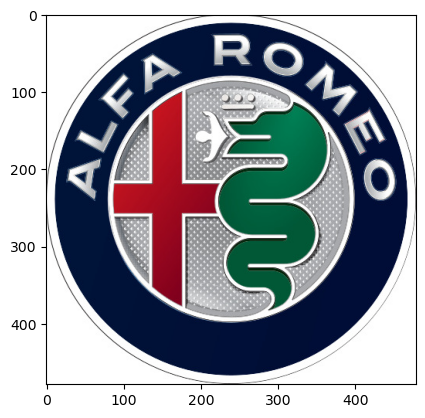

In [2]:
with open('settings.json', 'r') as settings_file:
    settings = json.load(settings_file)
loc_input_img = os.path.join('data', 'raw_data', settings['image_name'])
image = Image.open(loc_input_img)
np_image = np.array(image)
plt.imshow(np_image)
plt.show()

In [3]:
#Make your image recipes: an image recipe is a dict 
# rows = (int): How many rows in the final grid
# cols = (int): How many colums in the final grid
# cells = list(a) of lists(b,c,...). 
#   len(a) should be equal to rows*cols

#Instructions for Image ONE
#you just repeat the same image ove ran over. So 24 copies of the same cell
recipe_image_one = {
    'cols': 8,
    'rows': 3,
    'cells': 24*[[1, False, False] ]
}

#instructions for Image TWO
cellcommands_image_two = []
cellcommands_image_two.extend(6*[[1, False, False ]])           
#second row: no size increase, no color mod and  mirror over the Y axis
cellcommands_image_two.extend(6*[[1, False, 'mirror_y' ]])
#third row: no size increase, no color mod and mirror over the X axis
cellcommands_image_two.extend(6*[[1, False, 'mirror_x' ]])      
#fourth row: no size increase, no color mod and rotate 180° over the cell center
cellcommands_image_two.extend(6*[[1, False, 'rot_180' ]])       
recipe_image_two = {
    'cols': 6,
    'rows': 4,
    'cells': cellcommands_image_two
}

#instructions for Image THREE
cellcommands_image_three = []
#Boost the blue channel using B
cellcommands_image_three.extend(4*[[1, 'B', False ]])
#Boost the red channel using R
cellcommands_image_three.append([1, 'R', False])
#stretch the image factor 2
cellcommands_image_three.append([2, False, False])
#skip cell (indicated by 0 for grow factor)
cellcommands_image_three.append([0, False, False])
#Boost the red channel using R
cellcommands_image_three.extend(2*[[1, 'R', False]])
#skip two more cells to compensate for grow factor 2*2
cellcommands_image_three.extend(2*[[0, False, False]])
#Boost the red channel using R
cellcommands_image_three.append([1, 'R', False])
#Boost the green channel using G
cellcommands_image_three.extend(4*[[1, 'G', False ]])
recipe_image_three = {
    'cols': 4,
    'rows': 4,
    'cells': cellcommands_image_three
}


In [4]:
def process_command(commands):
    """
        Function which takes the commands for a single cell, starts
        with copying th original image and passes it to all appropriate
        functions depending on the given list of commands. 
        It returns the modified image.
    """
    size_boost = commands[0]
    color_command = commands[1]
    warp_command = commands[2]
    #copy prevents carrying over changes to other cells.
    image = np_image.copy()
    if size_boost > 1:
       image = warp.resize(image, size_boost)        
    if color_command:
        image = color.command_interpreter(image, color_command)
    if warp_command:
        image = warp.command_interpreter(image, warp_command)
    return image


shape_width = np_image.shape[0]
shape_height = np_image.shape[1]
def convert_recipe_to_image_matrix(recipe):
    grid_width = recipe['cols']
    grid_height = recipe['rows']
    cells = recipe['cells']
    if len(cells) != grid_height*grid_width:
        raise Exception(f"Recipe is not valid: {len(cells)} cells given for a grid where {grid_height*grid_width} cells are expected.")
    #use dtype int!! otherwise the image is cyan (mixing float and int throws off plt)
    grid = np.ones((grid_height*shape_width, grid_width*shape_height, 3), dtype=int)
    for i in range(len(cells)):
        cell = cells[i]
        cell_image = process_command(cell)
        row_start = (i // grid_width) * shape_width
        col_start = (i % grid_width) * shape_height
        #If grow_factor is 0 ==> i.e.: the cell has to be hidden but row_start and col_start need to shift.
        if cell[0] != 0:
            # Add cell_image to the corresponding position in the grid
            grid[row_start:row_start + cell_image.shape[0], col_start:col_start + cell_image.shape[1], :] = cell_image
    return grid

<function matplotlib.pyplot.show(close=None, block=None)>

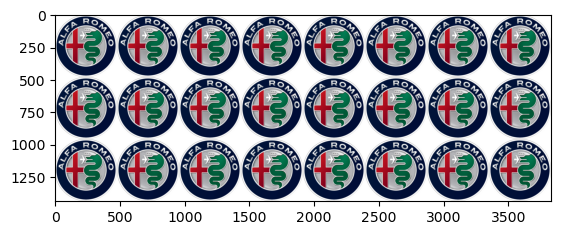

In [5]:
#image 1: simple 8*3 grid same image gets repeated all the time
plt.imshow(convert_recipe_to_image_matrix(recipe_image_one))
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

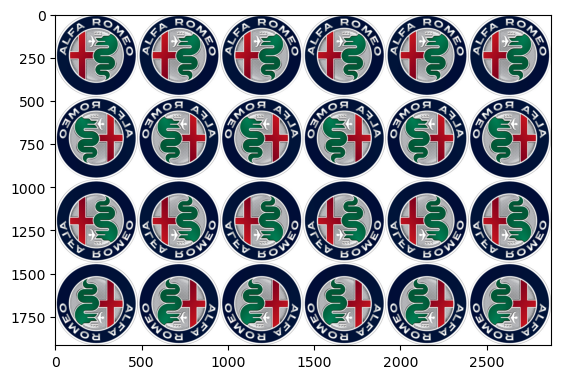

In [6]:
#image 2: 6*4 grid image flips and mirrors per row.
plt.imshow(convert_recipe_to_image_matrix(recipe_image_two))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

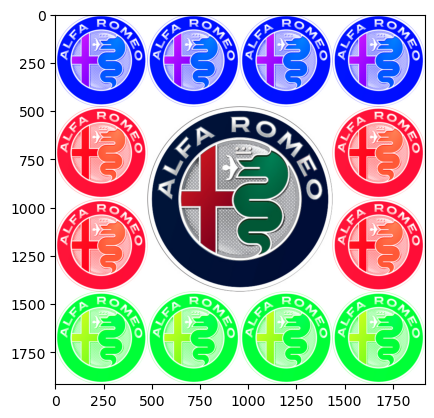

In [7]:
plt.imshow(convert_recipe_to_image_matrix(recipe_image_three))
plt.show

In [8]:
#first extra image will reuse the recipe-interpreter
#the goal is to create a checkered flag of n*m dimensions
#The newly used function for this is in color_functions.py
#and generates a negative. For the demonstration let's make a 
#board of chess: 
def checkered_recipe_maker(horizontal_repeat:int, vertical_repeat:int, top_left:bool= False): 
    #start with optimizing the matrix so that horizonal_repeat*matrix_width == max_width(less pixels to work with)
    # Create a 3D array with alternating True and False values based on the checkered pattern
    # use a 3D array to allow uneven grids
    check_pattern = np.zeros((horizontal_repeat, vertical_repeat, 3), dtype=object)
    #top_left is either 1, false, false OR 1, 'N', 'rot_180
    if top_left:
        first_box = np.array([1, False, False])
        second_box = np.array([1, 'N', 'rot_180'])
    else: 
        first_box = np.array([1, 'N', 'rot_180'])
        second_box = np.array([1, False, False])


    # Use NumPy array slicing to set alternate values in the check_pattern array
    #make the grid pattern by changinc collor to Negative
    check_pattern[::2, ::2] = first_box
    check_pattern[1::2, 1::2] = first_box
    check_pattern[::2, 1::2] = second_box
    check_pattern[1::2, ::2] = second_box
    print(check_pattern.shape)
    return check_pattern


recipe_image_extra_one = {
    'rows': 8,
    'cols': 8,
    'cells': checkered_recipe_maker(8, 8, False)
}
plt.imshow(convert_recipe_to_image_matrix(recipe_image_extra_one))
plt.show

(8, 8, 3)


Exception: Recipe is not valid: 8 cells given for a grid where 64 cells are expected.